In [1]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, create_mog
from distributions import log_prob_mix_laplace as log_p
from util import acf, ess, estimate_log_z
from math import log, pi, sqrt, exp
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange
%matplotlib inline

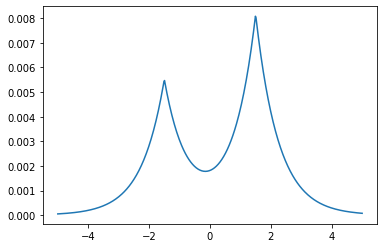

In [2]:
x_grid = torch.linspace(-5, 5, 500)
discrete_log_p = log_p(x_grid)
discrete_log_p = discrete_log_p - torch.logsumexp(discrete_log_p.flatten(),dim=0)
discrete_p = torch.exp(discrete_log_p)
discrete_p = discrete_p / discrete_p.sum()

plt.plot(x_grid, discrete_p)
plt.show()

Pick a few values of $\lambda$ and, for each one, configure the bounds of $\theta$-space that we will discretize

In [3]:
# NEED TO GET THESE RANGES BETTER
configs = [{'lambda': 1.0, 'log_sig_range': (-6, -2), 'mu_range': (-5, 5)},
           {'lambda': 4.0, 'log_sig_range': (-3, 1.5), 'mu_range': (-4, 4)},
           {'lambda': 16.0, 'log_sig_range': (-2, 1.5), 'mu_range': (-3, 3)},
           {'lambda': 64.0, 'log_sig_range': (-1, 1.5), 'mu_range': (-2, 2)}]

In [4]:
q = MVNIso(d=1)
for conf in configs:
    mu_grid = torch.linspace(*conf['mu_range'], 200)
    gam_grid = torch.linspace(*conf['log_sig_range'], 200)
    mm, gg = torch.meshgrid(mu_grid, gam_grid)
    theta_grid = torch.stack([mm.flatten(), gg.flatten()], dim=1)
    
    conf['logdet_fisher_grid'] = torch.tensor([q.set_theta(th).log_det_fisher() for th in theta_grid])

    conf['ent_q_grid'] = torch.tensor([q.set_theta(th).entropy() for th in theta_grid])
    conf['ce_qp_grid'] = torch.tensor([-q.set_theta(th).quadrature_ev(log_p, 25) for th in theta_grid])
    conf['kl_qp_grid'] = -conf['ent_q_grid'] + conf['ce_qp_grid']
    
    conf['mm'], conf['gg'] = mm, gg
    conf['discrete_log_psi'] = 0.5*conf['logdet_fisher_grid'] - conf['lambda'] * conf['kl_qp_grid']

## Figure 2

In [5]:
def sample_theta(psi, n, mm, gg):
    idx = torch.multinomial(psi.flatten(), num_samples=n, replacement=True)
    return torch.stack([mm.flatten()[idx], gg.flatten()[idx]], dim=1)

def log2prob(logp):
    p = torch.exp(logp - logp.max())
    return p / p.sum()

def log_q(x, theta):
    sig2 = torch.exp(2*theta[1])
    return -0.5*(x.view(-1,1)-theta[0])**2/sig2 - log(2*pi)/2 - theta[1]

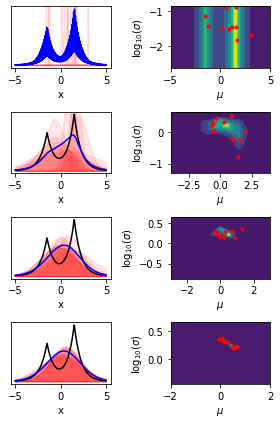

In [6]:
n_example_components = 10
fig, ax = plt.subplots(len(configs), 2, figsize=(4, 1.5*len(configs)))
for i, c in enumerate(configs):
    psi = log2prob(c['discrete_log_psi'])
    th_samples = sample_theta(psi, n_example_components, c['mm'], c['gg'])
    log_q_max = -c['gg'].min()  # log of peak height of the narrowest q kernel is roughly -log(sigma) for the min sigma
    discrete_m = sum((log_q(x_grid, (m, g)) - log_q_max).exp()*p for m, g, p in zip(c['mm'].flatten(), c['gg'].flatten(), psi.flatten()))
    discrete_m = discrete_m / discrete_m.sum()
    # PLOT1 : p, q, m
    log_q_values = log_q(x_grid, th_samples.T)
    q_values = log_q_values.exp() / log_q_values.exp().sum(dim=0, keepdims=True)
    ax[i,0].plot(x_grid, discrete_p, '-k')
    ax[i,0].plot(x_grid, discrete_m, '-b')
    yl = ax[i,0].get_ylim()
    for j in range(n_example_components):
        ax[i,0].fill_between(x_grid, q_values[:,j], color=(1.,0.,0.,.1))
    ax[i,0].set_yticks([])
    ax[i,0].set_ylim(yl)
    ax[i,0].set_xlabel('x')
    # PLOT2 : psi
    ax[i,1].contourf(c['mm'], c['gg']/log(10), psi.reshape(mm.size()), origin='lower', vmin=0.)
    ax[i,1].plot(th_samples[:,0], th_samples[:,1]/log(10), '.r')
    ax[i,1].set_xlabel(r'$\mu$')
    ax[i,1].set_ylabel(r'$\log_{10}(\sigma)$')
fig.tight_layout()